In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [4]:
in_size = 64

In [5]:
# input_dir = r'e:\kaggle\planet_amazon'
input_dir = 'inputs'

x_train = []
x_test = []
y_train = []
for f, tags in tqdm(df_train.values, miniters=1000):
    f_name = '{}.jpg'.format(f)
#     print(os.path.join(input_dir, 'train-jpg', f_name))
    img = cv2.imread(os.path.join(input_dir, 'train-jpg', f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (in_size, in_size)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [00:34<00:00, 1190.00it/s]


(40479, 64, 64, 3)
(40479, 17)


In [6]:
np.random.seed(0)
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', input_shape=(in_size,in_size,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='mean_squared_error', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
epochs = 40
loss = []
val_loss = []
f_score = []
val_f_score = []
for i in range(epochs):
    print("Epoch %d" % i)
    history = model.fit(X_train, Y_train,
              batch_size=256,
              epochs=1,
              verbose=2,
              validation_data=(X_valid, Y_valid))
    loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    p_train = model.predict(X_train, batch_size=128)
    p_valid = model.predict(X_valid, batch_size=128)
    f_score.append(fbeta_score(Y_train, np.array(p_train) > 0.2, beta=2, average='samples'))
    val_f_score.append(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))
print('Done')

Epoch 0
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
8s - loss: 0.0909 - acc: 0.2854 - val_loss: 0.0682 - val_acc: 0.2430
Epoch 1
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
5s - loss: 0.0686 - acc: 0.2674 - val_loss: 0.0632 - val_acc: 0.2591
Epoch 2
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
6s - loss: 0.0642 - acc: 0.2603 - val_loss: 0.0603 - val_acc: 0.2596
Epoch 3
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
6s - loss: 0.0613 - acc: 0.2568 - val_loss: 0.0585 - val_acc: 0.2568
Epoch 4
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
6s - loss: 0.0589 - acc: 0.2569 - val_loss: 0.0555 - val_acc: 0.2586
Epoch 5
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
7s - loss: 0.0562 - acc: 0.2589 - val_loss: 0.0534 - val_acc: 0.2610
Epoch 6
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
7s - loss: 0.0554 - acc: 0.2613 - val_loss: 0.0532 - val_acc: 0.2598
Epoch 7
Train on 32383 samples, validate on 8096

Train f-beta score 0.891780
Val f-beta score 0.879359


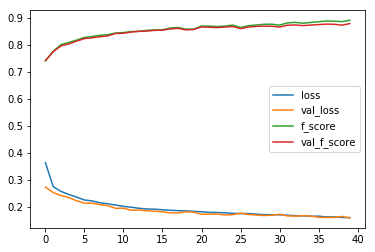

In [9]:
print("Train f-beta score %f" % f_score[-1])
print("Val f-beta score %f" % val_f_score[-1])
plt.plot(np.array(loss)*4)
plt.plot(np.array(val_loss)*4)
plt.plot(f_score)
plt.plot(val_f_score)
plt.legend(['loss', 'val_loss', 'f_score', 'val_f_score'], loc='right')
plt.show()

In [10]:
# model.save('starter_0.883.h5')